# Vector Moving Average (VMA) Model Notebook

This notebook reads two stock series from Yahoo Finance (using `Ticker.history`), conducts stationarity tests (ADF), computes lag correlation plots, and fits a Vector Moving Average (VMA) model (via `VARMAX` with no AR terms).

**Sections:**
1. Install Requirements  
2. Imports  
3. Data Download  
4. Stationarity Tests (ADF)  
5. Lag Correlation Plots  
6. VMA Model Fitting  
7. Residual Diagnostics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.varmax import VARMAX
import yfinance as yf
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Download close prices via Ticker.history
tickers = ['AAPL', 'MSFT']
data = pd.DataFrame()
for t in tickers:
    hist = yf.Ticker(t).history(start='2020-01-01', end='2025-01-01')
    data[t] = hist['Close']
data = data.dropna()
data.head()

,AAPL,MSFT
Date,,
2020-01-02 00:00:00-05:00,72.620850,153.042297
2020-01-03 00:00:00-05:00,71.914803,151.136673
2020-01-06 00:00:00-05:00,72.487862,151.527328
2020-01-07 00:00:00-05:00,72.146942,150.145737
2020-01-08 00:00:00-05:00,73.307510,152.537277


In [3]:
# Augmented Dickey-Fuller test
def adf_test(series, title=''):
    print(f'--- ADF Test: {title} ---')
    res = adfuller(series)
    out = pd.Series(res[:4], index=['Test Statistic','p-value','#Lags','Observations'])
    for k, v in res[4].items():
        out[f'Crit. Value ({k})'] = v
    print(out.to_string(), '\n')

# Test original
for col in data.columns:
    adf_test(data[col], title=col)

# Log returns
returns = np.log(data).diff().dropna()

# Test returns
for col in returns.columns:
    adf_test(returns[col], title=f'{col} Log Returns')

--- ADF Test: AAPL ---
Test Statistic         -0.708406
p-value                 0.844560
#Lags                   0.000000
Observations         1257.000000
Crit. Value (1%)       -3.435563
Crit. Value (5%)       -2.863842
Crit. Value (10%)      -2.567996 

--- ADF Test: MSFT ---
Test Statistic         -1.001772
p-value                 0.752618
#Lags                   9.000000
Observations         1248.000000
Crit. Value (1%)       -3.435601
Crit. Value (5%)       -2.863859
Crit. Value (10%)      -2.568004 

--- ADF Test: AAPL Log Returns ---
Test Statistic      -1.128437e+01
p-value              1.430072e-20
#Lags                8.000000e+00
Observations         1.248000e+03
Crit. Value (1%)    -3.435601e+00
Crit. Value (5%)    -2.863859e+00
Crit. Value (10%)   -2.568004e+00 

--- ADF Test: MSFT Log Returns ---
Test Statistic      -1.125107e+01
p-value              1.711504e-20
#Lags                8.000000e+00
Observations         1.248000e+03
Crit. Value (1%)    -3.435601e+00
Crit. Va

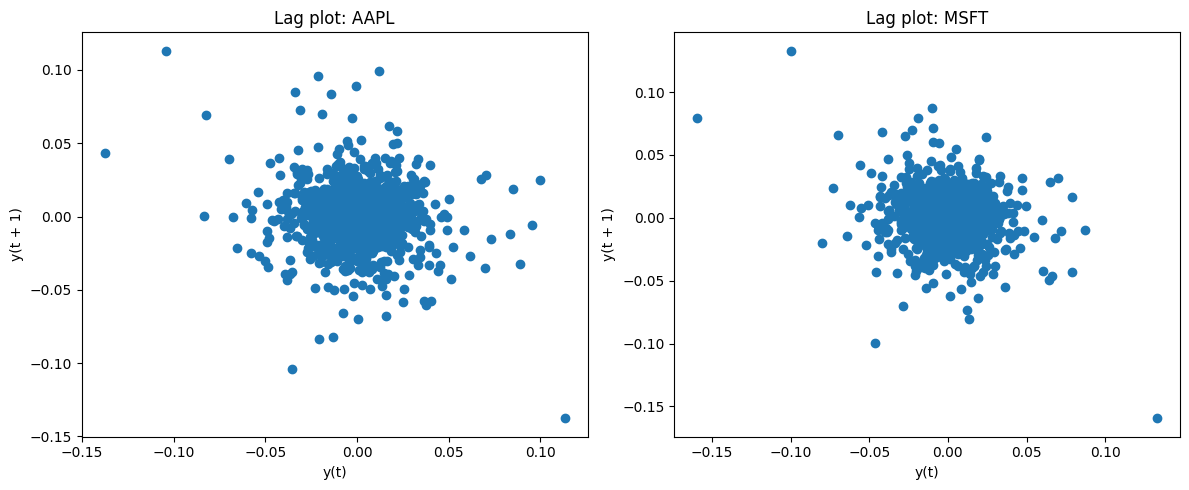

In [4]:
# Lag plots
plt.figure(figsize=(12,5))
for i, col in enumerate(returns.columns):
    plt.subplot(1,2,i+1)
    lag_plot(returns[col])
    plt.title(f'Lag plot: {col}')
plt.tight_layout()
plt.show()

In [5]:
# Fit VMA(1) model via VARMAX(order=(0,1))
model = VARMAX(returns, order=(0,1))
vma_res = model.fit(maxiter=1000, disp=False)
print(vma_res.summary())

/Users/hadi/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                           Statespace Model Results                           
Dep. Variable:       ['AAPL', 'MSFT']   No. Observations:                 1257
Model:                         VMA(1)   Log Likelihood                6867.999
                          + intercept   AIC                         -13717.998
Date:                Sun, 03 Aug 2025   BIC                         -13671.770
Time:                        02:39:58   HQIC                        -13700.624
Sample:                             0                                         
                               - 1257                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):             0.01, 0.00   Jarque-Bera (JB):      1125.06, 541.34
Prob(Q):                        0.92, 0.98   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.30, 0.85   Skew:                     -0.15, -0.08
Prob(H) (two-sided):            0.00,

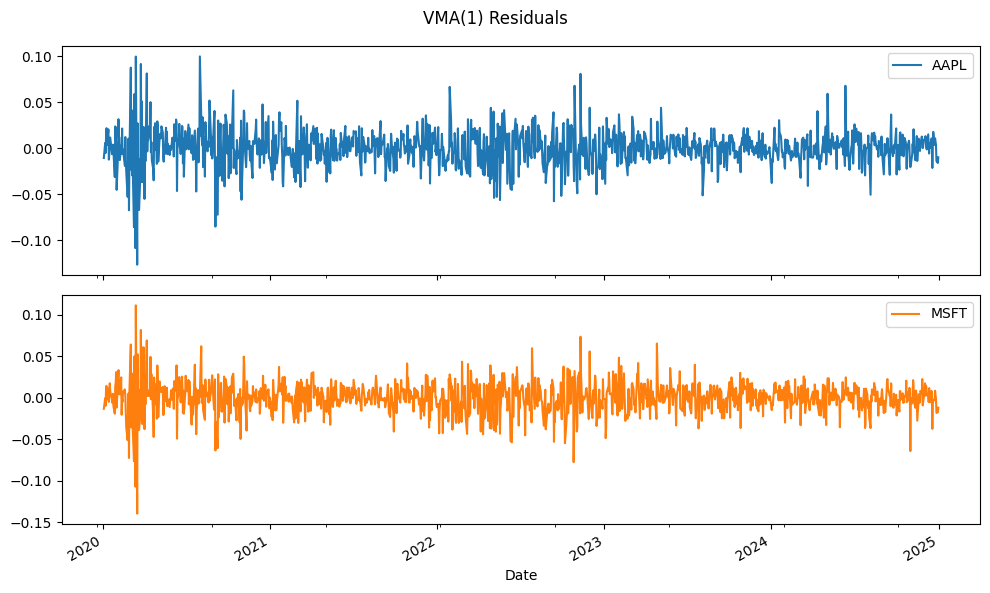

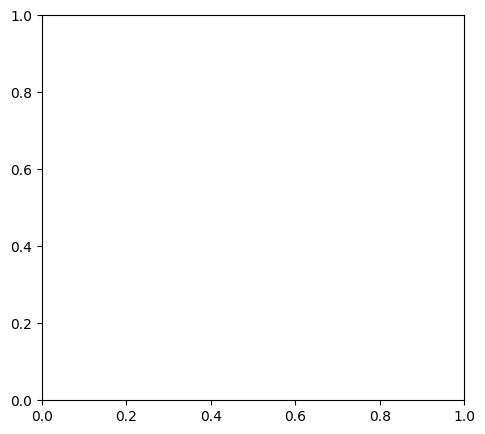

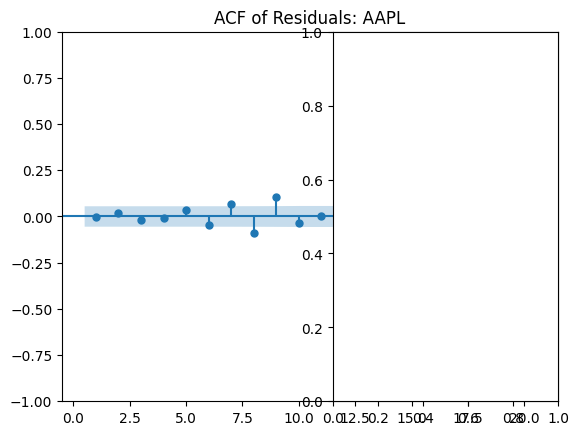

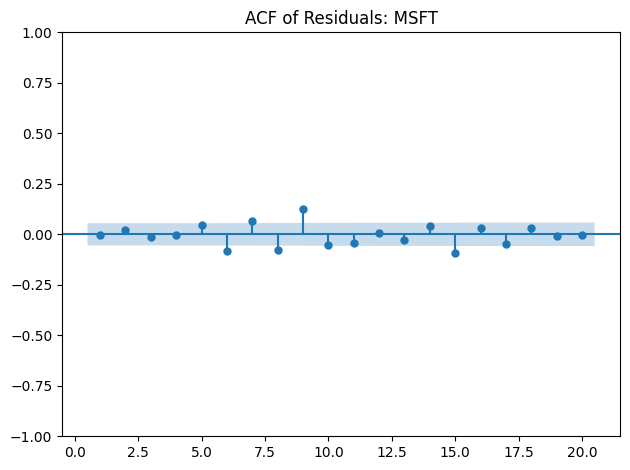

In [6]:
# Residuals and ACF
resid = vma_res.resid

# Plot residuals
resid.plot(subplots=True, figsize=(10,6), title='VMA(1) Residuals')
plt.tight_layout()
plt.show()

# ACF of residuals
plt.figure(figsize=(12,5))
for i, col in enumerate(resid.columns):
    plt.subplot(1,2,i+1)
    plot_acf(resid[col], lags=20, zero=False)
    plt.title(f'ACF of Residuals: {col}')
plt.tight_layout()
plt.show()